You should consider upgrading via the 'pip install --upgrade pip' command.


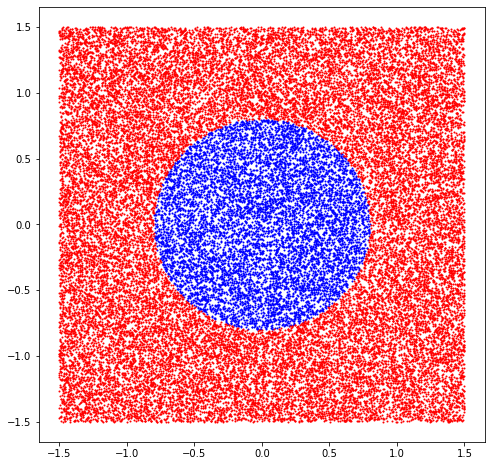

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
!pip install -q tensorflow==2.0.0-beta1

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

N=40000
K=3
X = K*np.random.rand(N,2) 
X[:,0] = X[:,0]-K/2
X[:,1] = X[:,1]-K/2

Y = np.zeros([N,2])

for i in range(N):
    if (X[i,0])**2+(X[i,1])**2<0.64:
        Y[i,0]=1
    else:
        Y[i,1]=1

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=1, facecolors='b', linewidths=1, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=1, facecolors='r', linewidths=1, label='Class 2')
plt.show()

data = X
labels = Y

In [76]:
num_hid1 = 9
num_hid2 = 3
model = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(num_hid1, input_shape=(2,), activation='relu',kernel_initializer='random_uniform',bias_initializer='random_uniform'))
# Add another:
model.add(Dense(num_hid2, activation='relu',kernel_initializer='random_uniform',bias_initializer='random_uniform'))
# Add a softmax layer with 10 output units:
model.add(Dense(2, activation='softmax'))

# Configure a model for categorical classification.
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

#model.fit(data, labels, epochs=5, steps_per_epoch = 500, batch_size=100,callbacks=[tensorboard])
model_name = str(num_hid1)+'_'+str(num_hid2)+'_'+'2'
model.save(model_name+'model.h5') 

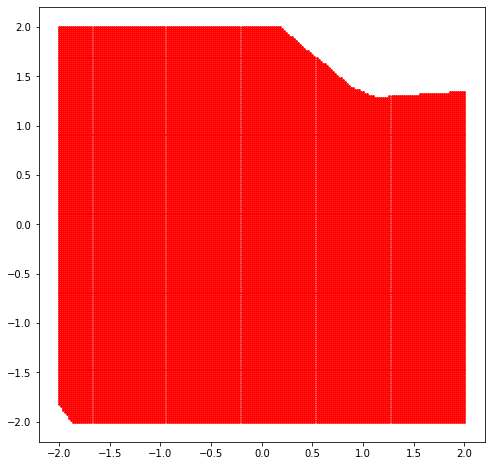

In [100]:
#test
import numpy as np
Grid = 200
k = 2
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()
#np.random.shuffle(X_test)

Y_test = model.predict(X_test)
Y_test = np.rint(Y_test)

zero_class_test = np.where(Y_test[:, 0])
one_class_test = np.where(Y_test[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
plt.show()

In [23]:
from tensorflow.keras import backend as K
#Return the activation matrix of a given input data to a model
get_second_layer_output = K.function(model.layers[0].input,model.layers[0].output)
get_third_layer_output = K.function(model.layers[0].input,model.layers[1].output)

def get_act_mat(data):    
    [second_layer_output] = get_second_layer_output(data.reshape(1,2))
    [third_layer_output] = get_third_layer_output(data.reshape(1,2))
    
    second_layer_nonzero_index = np.flatnonzero(second_layer_output)
    third_layer_nonzero_index = np.flatnonzero(third_layer_output)
    second_layer_output[second_layer_nonzero_index] = 1
    third_layer_output[third_layer_nonzero_index] = 1
    
    act_mat = [second_layer_output, third_layer_output]

    return act_mat

def get_act_matrix(hid1, hid2):
    matrix = []
    for i in range(2**hid1):
        first_layer_act = np.asarray([int(x) for x in list(('{:0'+str(hid1)+'b}').format(i))])
        for j in range(2**hid2):
            second_layer_act = np.asarray([int(x) for x in list(('{:0'+str(hid2)+'b}').format(j))])
            matrix.append([first_layer_act, second_layer_act])
    return matrix  

activation_matrix = get_act_matrix(num_hid1,num_hid2)

def assign_color(activation_matrix,activations,act_index):
    for index in range(len(activation_matrix)):
        if (activation_matrix[index][0] == activations[act_index][0]).all() and (activation_matrix[index][1] == activations[act_index][1]).all():
            return index

R = range(0,255,13)
G = range(0,255,13)
B = range(0,255,13)
rv,gv,bv = np.meshgrid(R,G,B)
colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
#np.random.shuffle(colors)

In [102]:
import multiprocessing
from multiprocessing import Pool
from functools import partial
import pdb

Grid = 200
k = .1
x = np.linspace(-k,k,Grid+1)
y = np.linspace(-k,k,Grid+1) 

xv,yv = np.meshgrid( x , y )
X_test = np.array([xv.flatten(),yv.flatten()])
X_test = X_test.transpose()


#loop for all data points to get activations
i_data = 0
activations = []

for test_data in X_test:
    print("get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test))), end="\r")
    activations.append(get_act_mat(test_data))
    i_data = i_data + 1
print(end="\n")

f = partial(assign_color,activation_matrix,activations)

i_color=0
data_activation_color=[]

pool = Pool(8)
for y in pool.map(f, range(len(activations))):
    i_color+=1
    print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
    data_activation_color.append(y)
print(end="\n")
# for y in range(len(activations)):
#     i_color+=1
#     print("get data color progress:{0}%".format(round((i_color + 1) * 100 / len(activations))), end="\r")
#     data_activation_color.append(f(y))
# print(end="\n")

data_activation_color = np.asarray(data_activation_color)
act_clusters = np.unique(data_activation_color)
cluster_index = []
for j in range(len(act_clusters)):
    cluster_index.append(np.where(data_activation_color == act_clusters[j]))

pool.close()
pool.join()

get activation progress:100%
get data color progress:100%


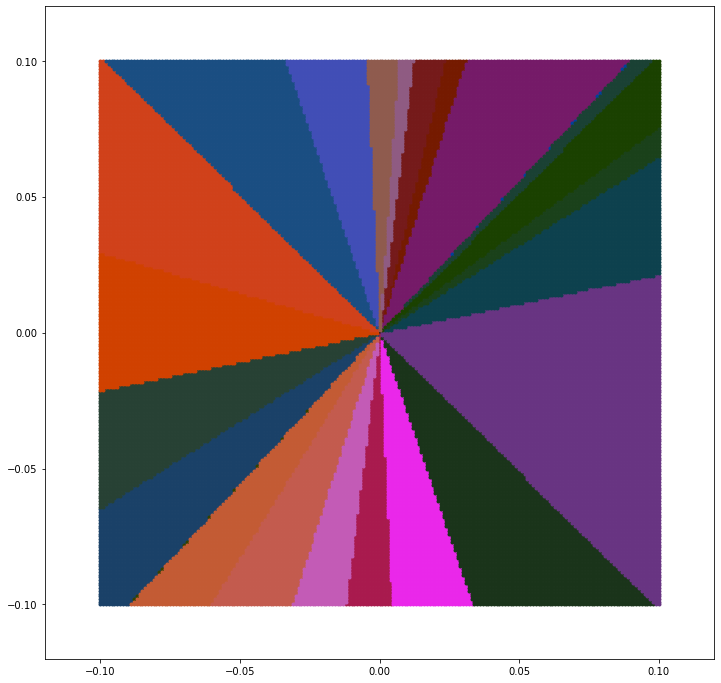

<Figure size 432x288 with 0 Axes>

In [105]:
progress = 0
plt.figure(figsize=(12, 12))
for k in range(len(cluster_index)):
    plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
#plt.margins(x=0.5, y=0.5)
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)
plt.show()
plt.savefig('activation')

In [17]:
#save data and model
model.save(model_name+'model.h5')
np.save('colors.npy',colors)
np.save('activations.npy',activations)
np.save('data_activation_color.npy',data_activation_color)

In [478]:
#read data and model
from tensorflow.keras.models import load_model
model = load_model(model_name+'model.h5')
colors = np.load('colors.npy')
activations = np.load('activations.npy',allow_pickle=True)
data_activation_color = np.load('data_activation_color.npy')

In [96]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial(input_data, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_data)
    prediction = model(input_data)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_data)
  return gradient 

old_prediction : [[0.5000314 0.4999686]]
new_prediction : [[0.5000314 0.4999686]]


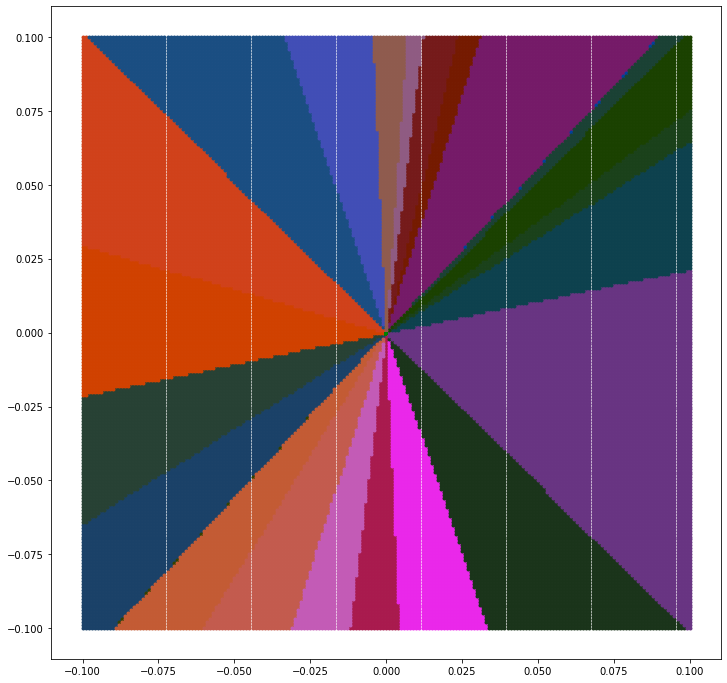

In [111]:
trajectory = []
seed = np.random.randint(40000)
test_x, test_y = [0.000,  0.0]
test = np.array([test_x,test_y])
label = np.array([1,0])
test_tensor = tf.constant(np.copy(test.reshape(1,2)))
trajectory.append(test_tensor)
for i in range(100):
    perturbations = create_adversarial(test_tensor, label)
    test_tensor = test_tensor-0.000005*perturbations/(np.linalg.norm(perturbations)+10**(-8))
    trajectory.append(test_tensor)
    
trajectory = np.asarray(trajectory)
trajectory = trajectory.reshape(len(trajectory),2)

old_prediction = model.predict(test.reshape(1,2))
print('old_prediction :',old_prediction)

new_prediction = model.predict(test_tensor)
print('new_prediction :',new_prediction)

plt.figure(figsize=(12, 12))
for k in range(len(cluster_index)):
    #print("Progress:{0}%".format(round((progress + 1) * 100 / len(cluster_index))), end="\r")
    plt.scatter(X_test[cluster_index[k], 0], X_test[cluster_index[k], 1], marker='o',s=4, color=colors[data_activation_color[cluster_index[k]][0]]/255.0, linewidths=2)
#print(end="\n")

#plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=1, facecolors='g', linewidths=1, label='Class 1')

for k in range(len(trajectory)):
    plt.scatter(trajectory[:,0], trajectory[:,1], marker='o',s=2, color='g', linewidths=1)
#plt.show()
plt.savefig('trajectory')

In [107]:
perturbations = create_adversarial(test_tensor,np.array([1,0]))
perturbations

<tf.Tensor: id=2087913, shape=(1, 2), dtype=float64, numpy=array([[2.03857394e-06, 1.57241891e-06]])>

In [108]:
trajectory[:]

array([[ 0.00000000e+00,  0.00000000e+00],
       [-3.94377634e-06, -3.04196398e-06],
       [-7.88755268e-06, -6.08392796e-06],
       [-1.18313290e-05, -9.12589194e-06],
       [-1.57751054e-05, -1.21678559e-05],
       [-1.97188817e-05, -1.52098199e-05],
       [-2.36626580e-05, -1.82517839e-05],
       [-2.76064344e-05, -2.12937478e-05],
       [-3.15502107e-05, -2.43357118e-05],
       [-3.54939870e-05, -2.73776758e-05],
       [-3.94377634e-05, -3.04196398e-05],
       [-4.33815397e-05, -3.34616038e-05],
       [-4.73253161e-05, -3.65035677e-05],
       [-5.12690924e-05, -3.95455317e-05],
       [-5.52128687e-05, -4.25874957e-05],
       [-5.91566451e-05, -4.56294597e-05],
       [-6.31004214e-05, -4.86714237e-05],
       [-6.70441977e-05, -5.17133876e-05],
       [-7.09879741e-05, -5.47553516e-05],
       [-7.49317504e-05, -5.77973156e-05],
       [-7.88755268e-05, -6.08392796e-05],
       [-8.28193031e-05, -6.38812435e-05],
       [-8.67630794e-05, -6.69232075e-05],
       [-9.

In [67]:
new_prediction = model.predict(test_tensor)
print('new_prediction :',new_prediction)
print('old loss :', loss_object(label, old_prediction))
print('new loss :', loss_object(label, new_prediction))
print('cross entropy loss :', loss_object(np.array([1,0]), np.array([[0,1]]).astype(np.float32)))

new_prediction : [[0.9945633  0.00543674]]
old loss : tf.Tensor(0.6931242, shape=(), dtype=float32)
new loss : tf.Tensor(0.005451551, shape=(), dtype=float32)
cross entropy loss : tf.Tensor(16.118095, shape=(), dtype=float32)


In [57]:
def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

In [82]:
def get_static_matrix(input_data):
    weights1,biases1 = model.layers[0].get_weights()
    weights1 = np.transpose(weights1)

    weights2, biases2 = model.layers[1].get_weights()
    weights2 = np.transpose(weights2)

    weights3, biases3 = model.layers[2].get_weights()
    weights3= np.transpose(weights3)
    
    weight_matrix = [[weights1,biases1],[weights2,biases2],[weights3,biases3]]
    return weight_matrix

In [83]:
static_matrix = get_static_matrix(test.reshape(1,2))
static_activation = get_act_mat(test.reshape(1,2))

In [84]:
from sympy import Symbol
x = Symbol('x')
y = Symbol('y')
#input_data = np.array([-0.8,0.5])
input_symbol = np.array([x,y])
output1 = (np.dot(static_matrix[0][0], input_symbol)+static_matrix[0][1])*static_activation[0]
print(output1)
output2 = (np.dot(static_matrix[1][0], output1)+static_matrix[1][1])*static_activation[1]
print(output2)
output3 = np.dot(static_matrix[2][0], output2)+static_matrix[2][1]
print(output3)

[0 0.0460423864424229*x - 0.0474537275731564*y - 0.0285570621490479
 -0.0323890447616577*x - 0.0045403465628624*y - 0.0329432711005211 0
 0.0246715433895588*x + 0.0462115444242954*y - 0.0239858273416758
 0.0419491790235043*x + 0.0384315513074398*y - 0.0186425074934959
 -0.0197713859379292*x + 0.0448728688061237*y - 0.0434338338673115 0
 0.0459283851087093*x - 0.0383288487792015*y - 0.00207215547561646]
[0 0.00140785698648732*x - 0.00416763292472709*y + 0.00482777295563463 0]
[0.00114934262810368*x - 0.00340236133687744*y + 0.00394128473983812
 0.00109967781233576*x - 0.00325534020946072*y + 0.00377097592529782]


In [90]:
[second_layer_output] = get_second_layer_output(test.reshape(1,2))
print(second_layer_output)
[third_layer_output] = get_third_layer_output(test.reshape(1,2))
print(third_layer_output)
[final_layer_output] = K.function(model.layers[0].input,model.layers[2].output)(test.reshape(1,2))
print(final_layer_output)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0.]
[0.5000314 0.4999686]


In [62]:
softmax([1.21649765968323,-1.21649765968323])

array([0.919309, 0.080691])

In [502]:
equivalent_matrix = np.zeros((2,2))
equivalent_matrix[0,0] = output3[0].subs({x:1, y: 0})-output3[0].subs({x:0, y: 0})
equivalent_matrix[1,0] = output3[1].subs({x:1, y: 0})-output3[1].subs({x:0, y: 0})
equivalent_matrix[0,1] = output3[0].subs({x:0, y: 1})-output3[0].subs({x:0, y: 0})
equivalent_matrix[1,1] = output3[1].subs({x:0, y: 1})-output3[1].subs({x:0, y: 0})

In [503]:
equivalent_matrix

array([[ 9.77866609, -6.8425408 ],
       [-7.52356385,  5.20314597]])

In [596]:
sum = exp(output3[0])+exp(output3[1])
v1 = exp(output3[0])
v2 = exp(output3[1])
loss = -log(v1/sum)
sm = [(v1/sum).subs({x:test_x,y:test_y}),(v2/sum).subs({x:test_x,y:test_y})]
print('softmax :', sm)
print('loss :',loss.subs({x:test_x,y:test_y}))

softmax : [0.919309004701531, 0.0806909952984690]
loss : 0.0841329729884969


In [603]:
diff(loss, x,x).subs({x:test_x,y:test_y})

0

In [88]:
static_matrix[0][0]

array([[-0.02318076, -0.03062657],
       [ 0.04604239, -0.04745373],
       [-0.03238904, -0.00454035],
       [ 0.01388427,  0.01070939],
       [ 0.02467154,  0.04621154],
       [ 0.04194918,  0.03843155],
       [-0.01977139,  0.04487287],
       [ 0.02633708,  0.00019092],
       [ 0.04592839, -0.03832885]], dtype=float32)

In [87]:
static_activation

[array([0., 1., 1., 0., 1., 1., 1., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32)]